In [18]:
from google.colab import drive # 从 google.colab 库导入 drive 模块
drive.mount('/content/drive') # 将 Google Drive 挂载到 Colab 运行时环境的 /content/drive 目录

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd /content/drive/MyDrive/Predictive_Modeling_for_Energy_Usage
# 将当前工作目录更改为 Google Drive 中的指定路径

/content/drive/MyDrive/Predictive_Modeling_for_Energy_Usage


In [20]:
import pandas as pd # 导入 pandas 库，通常用于数据处理和分析
import numpy as np # 导入 numpy 库，通常用于数值计算和数组操作
import matplotlib.pyplot as plt # 导入 matplotlib.pyplot 模块，通常用于数据可视化
from tensorflow.keras.models import load_model # 从 tensorflow.keras.models 导入 load_model 函数，用于加载保存的 Keras 模型
import joblib # 导入 joblib 库，通常用于保存和加载 Python 对象，如 scikit-learn 模型或 StandardScaler

# Load the saved LSTM model and scaler
model = load_model("LSTM-Model.h5") # 加载名为 "LSTM-Model.h5" 的保存的 Keras LSTM 模型
scaler = joblib.load("scaler.pkl") # 使用 joblib 加载名为 "scaler.pkl" 的保存的 scaler 对象

print("✅ Model and Scaler loaded successfully!") # 打印一条消息，表示模型和 scaler 已成功加载

✅ Model and Scaler loaded successfully!


In [21]:
df = pd.read_csv("events测试.csv") # 使用 pandas 的 read_csv 函数读取名为 "events.csv" 的文件，并将其存储在 DataFrame `df` 中
print(df.columns) # 打印 DataFrame `df` 的所有列名

Index(['Start time UTC', 'End time UTC', 'Start time UTC+03:00',
       'End time UTC+03:00', 'Average Load In Nanjing'],
      dtype='object')


In [22]:
# Load your dataset
df = pd.read_csv("events测试.csv", parse_dates=["Start time UTC"], index_col="Start time UTC") # 读取CSV文件，将'Start time UTC'列解析为日期，并将其设为索引

# Resample to daily frequency
df_daily = df.resample("D").sum() # 将数据按天重新采样，并对同一天的值求和

# Select the feature column used during training
df_selected = df_daily[["Average Load In Nanjing"]] # 选择'Electricity consumption in Finland'这一列作为特征

# ----> Define n_days here
n_days = 60  # or any desired number of previous days for input # 定义用于预测的天数（模型输入的时间步长）

# ----> Scale the input data
scaled_input = scaler.fit_transform(df_selected.values) # 使用之前加载的scaler对选定的特征数据进行标准化

# Initialize 'predictions' as an empty list before the loop
predictions = [] # 初始化一个空列表来存储预测结果

# For last n days
for _ in range(10): # 循环进行60次预测，预测未来60天的数据
    X_input = scaled_input[-n_days:]  # Get the last n_days # 获取标准化后数据的最后n_days天作为模型输入
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))  # Shape for LSTM # 将输入数据重塑成LSTM模型所需的形状 (samples, timesteps, features)

    pred_scaled = model.predict(X_input, verbose=0) # 使用加载的模型进行预测（输出是标准化后的值）
    predictions.append(pred_scaled[0][0]) # Now you can append to the list # 将预测结果（标准化后的值）添加到predictions列表中

    # Append predicted value to sequence for next input
    scaled_input = np.vstack([scaled_input, [[pred_scaled[0][0]]]]) # 将当前的预测值添加到标准化后的数据序列中，用于下一次预测的输入

# After the loop, you can convert predictions to a NumPy array if needed
predictions = np.array(predictions).reshape(-1, 1) # 将predictions列表转换为NumPy数组，并重塑为列向量
predicted_actual = scaler.inverse_transform(predictions) # 使用scaler进行反向转换，将标准化后的预测值转换回原始的实际值

In [23]:
# Load your dataset
df = pd.read_csv("events测试.csv", parse_dates=["Start time UTC"], index_col="Start time UTC") # 读取CSV文件，将'Start time UTC'列解析为日期，并将其设为索引

# Resample to daily frequency
df_daily = df.resample("D").sum() # 将数据按天重新采样，并对同一天的值求和 [1]

# Select the feature column used during training
df_selected = df_daily[["Average Load In Nanjing"]] # 选择'Electricity consumption in Finland'这一列作为特征

In [24]:
# Print all 60 predicted values with corresponding day numbers
print("📈 Predicted Electricity Consumption for Next 5 Days (in MWh):\n") # 打印一个标题，说明即将输出的是未来60天的预测电力消耗数据
for i, value in enumerate(predicted_actual.flatten(), 1): # 遍历预测的实际值列表，同时获取索引（从1开始计数作为天数）和预测值
    print(f"Day {i}: {value:.2f} MWh") # 打印每一天的天数和对应的预测电力消耗值，保留两位小数并带单位MWh

📈 Predicted Electricity Consumption for Next 5 Days (in MWh):

Day 1: 1845.71 MWh
Day 2: 1809.60 MWh
Day 3: 1868.83 MWh
Day 4: 1789.10 MWh
Day 5: 1882.12 MWh
Day 6: 1844.25 MWh
Day 7: 1860.97 MWh
Day 8: 1817.06 MWh
Day 9: 1803.60 MWh
Day 10: 1792.71 MWh


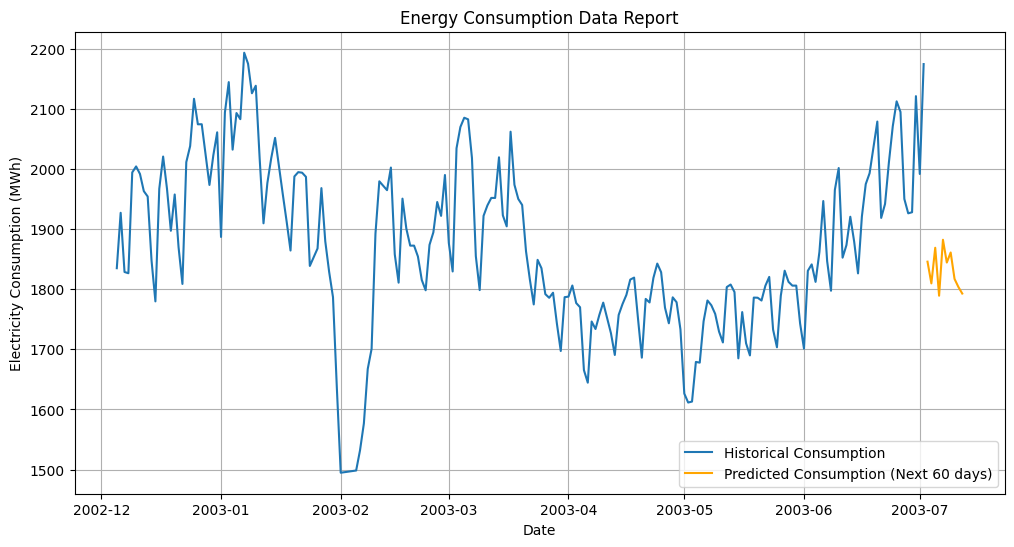

In [25]:
# Future dates
last_date = df_selected.index[-1] # 获取原始数据中的最后一天日期
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10) # 创建从最后一天后一天开始的未来60天的日期范围

# DataFrame for forecast
forecast_df = pd.DataFrame(predicted_actual, index=future_dates, columns=["Predicted Consumption"]) # 使用预测结果和未来日期创建预测结果的 DataFrame

# Plot
plt.figure(figsize=(12, 6)) # 创建一个图形，设置图的大小
plt.plot(df_selected[-210:], label="Historical Consumption") # 绘制历史电力消耗数据（最后90天）
plt.plot(forecast_df, label="Predicted Consumption (Next 60 days)", color='orange') # 绘制未来60天的预测电力消耗数据
plt.xlabel("Date") # 设置x轴标签为“Date”
plt.ylabel("Electricity Consumption (MWh)") # 设置y轴标签为“Electricity Consumption (MWh)”
plt.title("Energy Consumption Data Report") # 设置图的标题为“Electricity Forecast for Finland”
plt.legend() # 显示图例
plt.grid() # 显示网格线
plt.show() # 显示图形


In [26]:
# Save forecast_df to a CSV file
forecast_df.to_csv("electricity_forecast_n_days.csv") # 将预测结果的 DataFrame 保存为名为 "electricity_forecast_n_days.csv" 的CSV文件
print("📁 Predictions saved to electricity_forecast_n_days.csv") # 打印一条消息，表示预测结果已保存到CSV文件

📁 Predictions saved to electricity_forecast_n_days.csv
